In [1]:
import sqlite3
from requests.exceptions import Timeout, ConnectionError
import time
from time import sleep
import pandas as pd
import pyodbc
import spacy
import re

import nltk 
from nltk.corpus import stopwords

import wordcloud
from wordcloud import WordCloud


from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.coherencemodel import CoherenceModel

In [2]:
# Setting the connection strings
server = 'tcp:isye-6420-project.database.windows.net,1433' 
database = 'topic_modelling' 
username = 'project_administrator' 
password = 'isye_6420_admin' 
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
#SQLite cursor
c = conn.cursor()

In [3]:
# Method to read the twitter messages into the pandas dataframe
def read_sql():
    train_data =  pd.read_sql_query('select [tweet_text], [Political_party] from tweets_raw', conn) 
    return(train_data)

In [4]:
# Step 1 : Data Loading 
    
# Executing method to read twitter messages into dataframe
#train_data = read_sql()
    

In [5]:
train_data  = pd.read_pickle('train_data.p')

In [6]:
# Step 2: Data Cleaning 

# print the train_data column names 
print(train_data.columns)

# Load the regular expression library
#  Remove URLs
train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
# Remove punctuation
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('[,\.!?@]', '', x))
# Remove punctuation
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'']', '', x))
# Convert the titles to lowercase
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: x.lower())
# Removing the word 'amp' 
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('amp', '', x))

#remove times pm
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub('\d+pm', '', x))


Index(['tweet_text', 'Political_party'], dtype='object')


In [7]:
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("it's",'', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("n't",'', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("'",'', x))
train_data['tweet_text'] = train_data['tweet_text'].map(lambda x: re.sub("-",'', x))

In [8]:
# 5. Removing Stopwords 
STOPWORDS = set(stopwords.words('english','spanish'))
def remove(text,wordset=STOPWORDS):
    splits = text.split()
    result=[]
    for split in splits:
        if split not in wordset:
            result.append(split.strip())
    return (" ".join(result))        

train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: remove(x))


In [9]:
#  6. To retain only the Nouns and Adjectives in every tweet 

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    doc = nlp(texts) 
    texts_out = " ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out     

# Do lemmatization keeping only noun, adj parts of speech (POS)
train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: lemmatization(x, allowed_postags=['NOUN', 'ADJ']))


In [10]:
# 7. To eliminate additional words 

eliminate_words = {'today', 'year', 'people', 'time', 'great', 'day', 'morning', 'evening', 'community', 'important',
                   'many', 'family', 'sure', 'visit', 'https', 'new', 'work', 'proud', 'thank', 'good', 'way', 'help',
                   'need', 'member', 'week', 'nation', 'support', 'last', 'effort', 'yesterday', 'news', 'watch', 'state',
                   'safe', 'happy', 'birthday', 'colleague', 'tonight', 'part', 'much', 'now', 'country', 'leader', 'program',
                   'congratulation', 'conversation', 'fact', 'government', 'house', 'right', 'tomorrow', 'question', 'long',
                   'public', 'big', 'million', 'benefit', 'information', 'report' , 'friend', 'life', 'bad' , 'word', 'true',
                   'woman', 'man', 'local', 'action', 'resource', 'high','school', 'opportunity', 'town', 'event', 'meeting',
                   'tune', 'pm', 'student', 'live', 'discussion', 'discuss', 'child', 'world', 'policy', 'condition', 'hand',  
                   'office', 'place', 'resident', 'site' , 'concern', 'city', 'free', 'congressional', 'WORKER', 'history',
                   'wonderful', 'team', 'update', 'facebook', 'minute', 'op', 'water', 'food', 'hour', 'pm', 
                   'thing', 'art', 'folk', 'annual', 'prayer', 'thought', 'heart', 'statement', 'story', 'special', 'pre',
                   'honor', 'young', 'neighbor', 'night', 'district', 'late', 'moment', 'case', 'census', 'person', 'voice', 
                   'wrong',  'share', 'victory', 'grateful', 'century', 'kid', 'difficult', 'afternoon', 'love', 'youth', 
                   'fellow', 'mother',  'comment', 'official','p','m','p m', 'crisis', 'issue'}



train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: remove(x, wordset=eliminate_words ))

In [11]:
extra_words = {'today','thank','11','wa','con','por','del','los','que','para','en','el','la','de','sure','know','make','going','your',
'about','they','ve','we','re','ing','im','proud','ago','act','tonight','tune','live','morning','listen','join','discuss',
'forward','great','will','see','must','tomorrow','day','one','host','hall','god','bless','about','happy','birthday',
'birth','fireside','chat','celebrating','christmas','roshhashanah','graduation','high','celebration','yom kippur','time',
'year','new','easter','art','competition','guest','hosting','seanhannity','facebook','ill','wolfblitzer','joining',
'fridayswithfrank','town','hold','sunday','night','thanks','watching','point','good','nightclub','camdencountynj',
'weekly','update','page','yom','kippur','congratulations','congratulation','eaglej','scout','weeks','week','todays',
'daily','yesterday','youll','cnnsitrom','shortly','minute','happening','soon','foxnews','900p','ne02','gobierno',
'estados','unidos','visite','nuestra','pagina ','federales','estados','agencias','kbtxnews','totally','agree','wtaw1620',
'icymi','segment','coming','soon','et','praying','speedy','frequently','asked','question','thought','share','noon','newsletter',
'clicking','exactly','right','1000p','1100p','wishing','algal','bloom','app','receive','245th','244th','start','hour',
'olg','youve','loudobbs','foxbusiness','free','feel','passionate','west','palm','sign','link','va','inside','ill',
'foxandfriend','valley','watch','informacion','espanol','acerca','sus','link','servicios','pagina','ill','foxandfriend',
'valley','watch','informacion','espanol','acerca','kwtx','ne03', 'quid','foxnewsnight','pagina','espanol','quid','passover',
'simonradio1776','whoradio', '800wvhu','ill3'}

train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: remove(x,extra_words))


In [12]:
def replace_synonyms(text):
    splits = text.split()
    result=[]
    for split in splits:
        if split in synonyms:
            result.append(synonyms[split])
        else:
            result.append(split)
    return (" ".join(result))        

#replace synonyms
synonyms = {'donald':'trump','realdonaldtrump':'trump','joebiden':'biden'}

train_data['tweet_text'] = train_data['tweet_text'].apply(lambda x: replace_synonyms(x))


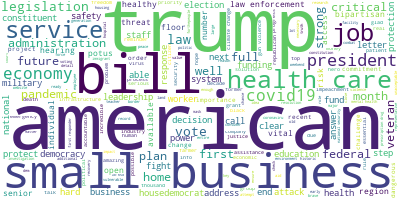

In [13]:
# Step 3: Exploratory Analysis 

# Import the wordcloud library
train_data_all = train_data.loc[(train_data['Political_party'] == "Republican Party") | (train_data['Political_party'] == "Democratic Party") ]

# Join the different processed tweets together.
long_string_all = ','.join(list(train_data['tweet_text'].values))

# Create a WordCloud object
wordcloud_all = WordCloud(background_color="white", max_words=5000, contour_width=10, contour_color='steelblue')

# Generate a word cloud
wordcloud_all.generate(long_string_all)
# Visualize the word cloud
wordcloud_all.to_image()


In [14]:
# Step 4: Data Preparation before training Model 

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()




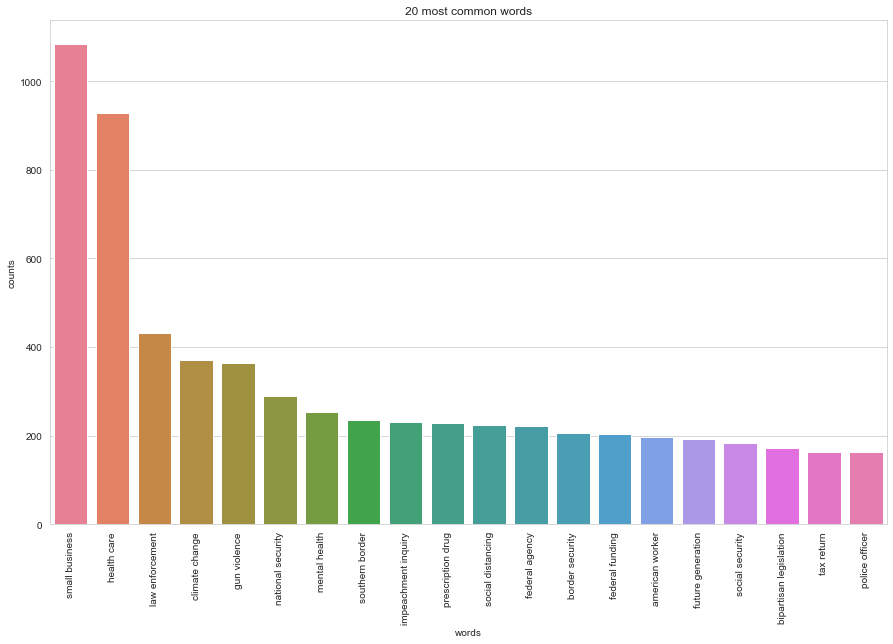

In [15]:
# 20_most_common_words in Democrats tweets
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(n_features=10)
hv.transform(train_data_all["tweet_text"])   

from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer_dem = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english', max_features= 1000)
# Fit and transform the processed tweets
count_data_dem = count_vectorizer_dem.fit_transform(train_data_all['tweet_text'])
# Visualise the 20 most common words
plot_20_most_common_words(count_data_dem, count_vectorizer_dem)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
count_vectorizer_all =TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', use_idf=True, lowercase=True, strip_accents="ascii", stop_words='english')

# Calculate DocTerm Matrices
count_data_all = count_vectorizer_all.fit_transform(train_data_all['tweet_text'])


In [17]:
from gensim import corpora
from sklearn.decomposition import NMF

# Create Dictionary
text_all=[[text for text in doc.split()] for doc in train_data_all['tweet_text']]
dictionary_all = corpora.Dictionary(text_all)
corpus_all=[dictionary_all.doc2bow(text) for text in text_all]


In [18]:
#Build manual tokenized topics
def TokenTopics(DocTerm, TopicAffinity,NumTerms=10):
    result=[]
    for i,topic in enumerate(TopicAffinity):
        result.append([DocTerm.get_feature_names()[i] for i in topic.argsort()[-NumTerms:]]) 
    return result

def CalculateCoherence(corpus1,dictionary1,text1,tt,coherence1='c_v'):
    cm=0
    if coherence1[0]=='u':
        cm = CoherenceModel(topics=tt, corpus=corpus1, dictionary=dictionary1, coherence=coherence1,processes=-1)    
    else: 
        cm = CoherenceModel(topics=tt, texts=text1, dictionary=dictionary1, coherence=coherence1,processes=-1)
    return cm.get_coherence()




In [20]:
#Try different topic sizes, parameters
coherence_all = dict()

for a in range(15,35):
    
    print(a)

    nmf_all = NMF(n_components=a, init='nndsvd', random_state=42, max_iter=1000, solver='cd',alpha=.1, l1_ratio=.5)
    nmf_all.fit(count_data_all)
    tt = TokenTopics(count_vectorizer_all,nmf_all.components_)
    
    label='p'+str(a)
    coherence_all[label]=CalculateCoherence(corpus_all,dictionary_all,text_all,tt,'c_v')
    
    

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [21]:
coherence_score = list(coherence_all.values())
coherence_score

[0.5667799461436318,
 0.5631655041299028,
 0.5890007884910228,
 0.5807854453120265,
 0.5660287845061016,
 0.5745898873747229,
 0.5643837556930568,
 0.5531603555535465,
 0.5391192895660462,
 0.5368496309458195,
 0.536620660620634,
 0.5594416054970883,
 0.5435576099755761,
 0.5564618795426574,
 0.5562863846695393,
 0.5461001375427323,
 0.5263919659546047,
 0.5289202243101288,
 0.5385734246942996,
 0.5482190568137822]

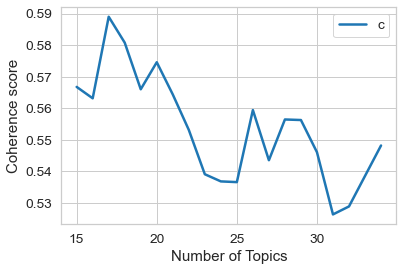

In [22]:
# Show graph
x = range(15,35)
plt.plot(x, coherence_score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
#Train final model
nmf_all_m = NMF(n_components=17, random_state=42, max_iter=1000, solver='cd',alpha=.1, l1_ratio=.5)
nmf_all = nmf_all_m.fit_transform(count_data_all)

In [24]:
terms = count_vectorizer_all.get_feature_names()
topic_all = dict()

for i, comp in enumerate(nmf_all_m.components_):
    print_topic = [] 
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    label = "topic_" + str(i)
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print_topic.append(t[0])
    print(print_topic)
    topic_all[label] = print_topic[0] + '-' + print_topic[1] + '-' + print_topic[2]
    
        

Topic 0: 
['health', 'care', 'affordable', 'access', 'mental', 'pandemic', 'coverage', 'quality', 'provider', 'patient']
Topic 1: 
['business', 'small', 'loan', 'owner', 'relief', 'paycheck', 'ppp', 'employee', 'protection', 'fund']
Topic 2: 
['american', 'citizen', 'truth', 'democracy', 'native', 'political', 'value', 'deal', 'hero', 'trade']
Topic 3: 
['service', 'sacrifice', 'brave', 'postal', 'military', 'freedom', 'academy', 'critical', 'essential', 'hero']
Topic 4: 
['vote', 'election', 'ballot', 'mail', 'democracy', 'voter', 'voting', 'housedemocrat', 'floor', 'amendment']
Topic 5: 
['border', 'security', 'national', 'southern', 'wall', 'immigration', 'secure', 'social', 'emergency', 'humanitarian']
Topic 6: 
['job', 'unemployment', 'wage', 'growth', 'month', 'economic', 'rate', 'manufacturing', 'investment', 'low']
Topic 7: 
['covid19', 'testing', 'relief', 'response', 'mask', 'virus', 'spread', 'package', 'pandemic', 'available']
Topic 8: 
['trump', 'president', 'election', 'p

In [25]:
topic_all

{'topic_0': 'health-care-affordable',
 'topic_1': 'business-small-loan',
 'topic_2': 'american-citizen-truth',
 'topic_3': 'service-sacrifice-brave',
 'topic_4': 'vote-election-ballot',
 'topic_5': 'border-security-national',
 'topic_6': 'job-unemployment-wage',
 'topic_7': 'covid19-testing-relief',
 'topic_8': 'trump-president-election',
 'topic_9': 'federal-agency-funding',
 'topic_10': 'law-enforcement-officer',
 'topic_11': 'veteran-sacrifice-military',
 'topic_12': 'worker-essential-frontline',
 'topic_13': 'impeachment-inquiry-article',
 'topic_14': 'violence-legislation-gun',
 'topic_15': 'drug-prescription-cost',
 'topic_16': 'economy-strong-future'}

In [26]:
nmf_all.shape

(99402, 17)

In [27]:
pd.options.display.float_format = '{:,.16f}'.format
topic_encoded_df = pd.DataFrame(nmf_all, columns = ["topic_0", "topic_1", "topic_2", "topic_3","topic_4","topic_5", "topic_6", "topic_7", "topic_8", "topic_9", "topic_10", "topic_11", "topic_12", "topic_13", "topic_14", "topic_15", "topic_16"])

topic_encoded_df["probable_Topic"] = topic_encoded_df.idxmax(axis=1)
topic_encoded_df["Topic_Probability"] = topic_encoded_df.max(axis=1)
topic_encoded_df["documents"] = train_data_all['tweet_text'].values

topic_encoded_df["probable_Topic"].replace(topic_all, inplace=True)
display(topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]])


,documents,probable_Topic,Topic_Probability
0,,health-care-affordable,0.0000000000000000
1,single climate change presidential debate lett...,economy-strong-future,0.0061103952466356
2,doubt commanderinchief demconvention,health-care-affordable,0.0000000000000000
3,next generation service future first step well...,service-sacrifice-brave,0.0241869999799447
4,mayor dear vote text vote plan vote,vote-election-ballot,0.0764176444514893
...,...,...,...
99397,company manufacturing job,job-unemployment-wage,0.0515308924119989
99398,freedom economy american dream calm defend fre...,economy-strong-future,0.0246232542754599
99399,hearing clear justice scotus constitution,impeachment-inquiry-article,0.0051992228287433
99400,abortion covid19 prevent abortion reaction,covid19-testing-relief,0.0249625019701168


In [28]:
#democ_data =  pd.read_sql_query("select [tweet_text] from tweets_raw", conn) 

democ_data  = pd.read_pickle('train_data.p')
democ_data = democ_data.loc[(democ_data['Political_party'] == "Republican Party") | (democ_data['Political_party'] == "Democratic Party") ]
democ_data = democ_data.reset_index(drop=True)


In [29]:
democ_topic_model = topic_encoded_df[["documents", "probable_Topic", "Topic_Probability"]]
democ_topic_model = democ_topic_model.reset_index(drop=True)

democ_topic_model["documents"] = democ_data["tweet_text"]
democ_topic_model

,documents,probable_Topic,Topic_Probability
0,Love it! https://t.co/NZh4aQp5Cc,health-care-affordable,0.0000000000000000
1,"In 2016, there wasn't a single question on cli...",economy-strong-future,0.0061103952466356
2,"Without a doubt, @JoeBiden is the Commander-in...",health-care-affordable,0.0000000000000000
3,A leader among the next generation of Democrat...,service-sacrifice-brave,0.0241869999799447
4,A moving tribute from Mayor @KeishaBottoms for...,vote-election-ballot,0.0764176444514893
...,...,...,...
99397,#GoodNews: companies continue to invest in SW ...,job-unemployment-wage,0.0515308924119989
99398,Freedom surrendered is rarely reclaimed. It’s ...,economy-strong-future,0.0246232542754599
99399,"#ConfirmACB Watching the hearing, it seems cle...",impeachment-inquiry-article,0.0051992228287433
99400,Abortion kills more than 4x as many people per...,covid19-testing-relief,0.0249625019701168


In [30]:
topic_modelling_NMF= democ_topic_model.reset_index(drop=True)

In [31]:
topic_modelling_NMF

,documents,probable_Topic,Topic_Probability
0,Love it! https://t.co/NZh4aQp5Cc,health-care-affordable,0.0000000000000000
1,"In 2016, there wasn't a single question on cli...",economy-strong-future,0.0061103952466356
2,"Without a doubt, @JoeBiden is the Commander-in...",health-care-affordable,0.0000000000000000
3,A leader among the next generation of Democrat...,service-sacrifice-brave,0.0241869999799447
4,A moving tribute from Mayor @KeishaBottoms for...,vote-election-ballot,0.0764176444514893
...,...,...,...
99397,#GoodNews: companies continue to invest in SW ...,job-unemployment-wage,0.0515308924119989
99398,Freedom surrendered is rarely reclaimed. It’s ...,economy-strong-future,0.0246232542754599
99399,"#ConfirmACB Watching the hearing, it seems cle...",impeachment-inquiry-article,0.0051992228287433
99400,Abortion kills more than 4x as many people per...,covid19-testing-relief,0.0249625019701168


In [67]:
topic_modelling_NMF.to_pickle('topic_modelling_NMF.p')

In [68]:
count = topic_modelling_NMF[['documents', 'probable_Topic']].groupby(by='probable_Topic').agg('count')
count.reset_index(inplace=True)

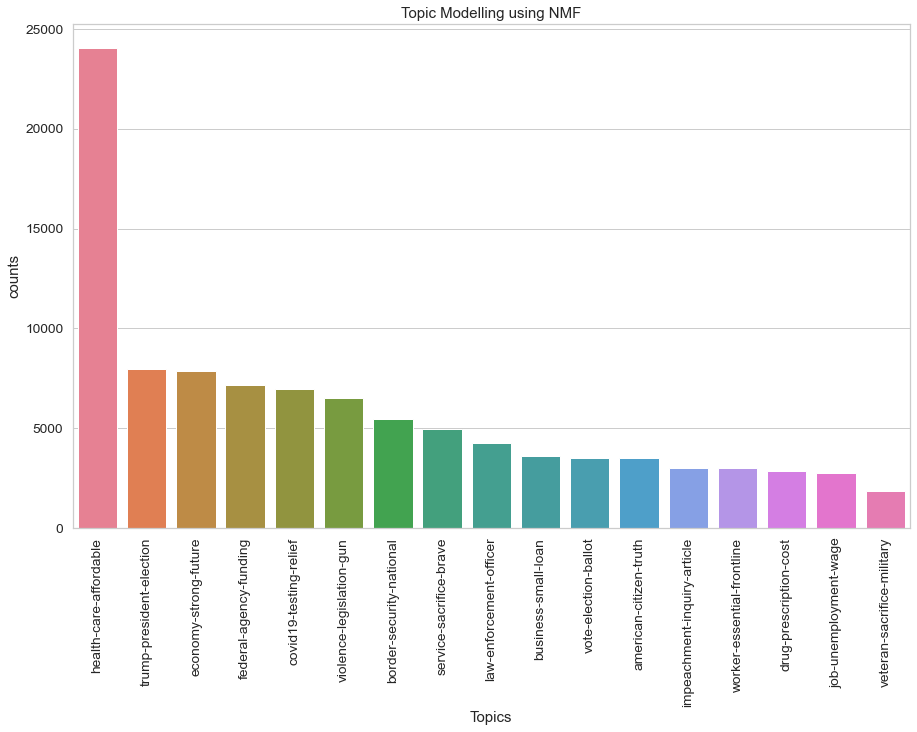

In [69]:
# Graph to visualize the distribution of Tweets Vs Topics modelled by NMF
import matplotlib.pyplot as plt

count = count.sort_values(by=['documents'], ascending=False)
topics = count['probable_Topic']
x_pos = np.arange(len(topics)) 

    
plt.figure(2, figsize=(15, 15/1.6180))
plt.subplot(title='Topic Modelling using NMF')
sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.barplot(x=x_pos, y="documents", data=count, palette='husl')
plt.xticks(x_pos, topics, rotation=90) 
plt.xlabel('Topics')
plt.ylabel('counts')
plt.show()